In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from fnsa.classifier.classifier import NBSVM
from fnsa.classifier.data import load as load_data
from fnsa.classifier.util import cross_validate, evaluate, plot_confusion_matrix

In [3]:
include_words = True
fname = 'all-agree'
if include_words: fname = 'all-agree-with-words'
classes = [-1, 0, 1]
sentences, X, y = load_data(fname + ".tsv")

# For comparison with the paper results compute the weighted average of the accuracies they report:

lps_accuracies = {-1: 0.951, 0: 0.828, 1: 0.869}
lps_cnts = dict(Counter(y))
n_lps_records = sum(lps_cnts.values())
n_records = len(y)
lps_accuracy = sum([lps_accuracies[key] * lps_cnts[key] for key in classes]) / n_records
print("n_records:", n_records)
print("n_lps_records:", n_lps_records)
print("lps_accuracy: %0.3f" % lps_accuracy)

n_records: 2264
n_lps_records: 2264
lps_accuracy: 0.855


## Naive Bayes

Fold 01 accuracy = 0.855.
Fold 02 accuracy = 0.846.
Fold 03 accuracy = 0.894.
Fold 04 accuracy = 0.916.
Fold 05 accuracy = 0.876.
Fold 06 accuracy = 0.858.
Fold 07 accuracy = 0.876.
Fold 08 accuracy = 0.916.
Fold 09 accuracy = 0.876.
Fold 10 accuracy = 0.912.
Average Accuracy = 0.883.


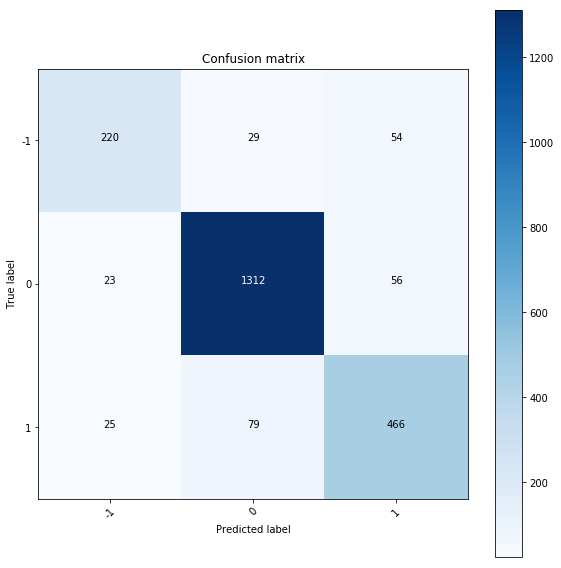

In [4]:
alpha=0.025
binary = True
ngram_range = (1,2)
use_fs = False
use_idf = True

pipeline = [('vectorizer', CountVectorizer(ngram_range=ngram_range, binary=binary))]
if use_fs: pipeline.append(('feature-selector', SelectFromModel(ExtraTreesClassifier())))
if use_idf: pipeline.append(('transformer', TfidfTransformer()))
pipeline.append(('estimator', MultinomialNB(alpha)))
    
classifier = Pipeline(pipeline)
classifier = classifier.fit(X, y)

accuracy, cm = cross_validate(classifier, X, y, n_splits=10, shuffle=True, random_state=None)
plot_confusion_matrix(cm, classes)
print("Average Accuracy = %0.3f." % (accuracy,))

path = './model/nb-%s.pkl' % fname
joblib.dump(classifier, path);

In [5]:
path = './model/nb-%s.pkl' % fname
joblib.dump(classifier, path)
classifier_loaded = joblib.load(path)

In [ ]:
y_predicted = classifier.predict(X)

In [ ]:
code2position = {-1:0, 0:1, 1:2}
code2sentiment = {-1:'-', 0:'=', 1:'+'}
def correct_confidence(index):
    x = X[index]
    probs = classifier.predict_proba([x])[0]
    position = code2position[y[index]]
    return probs[position]    

In [ ]:
indices = range(len(y))
indices = sorted(indices, key=lambda index: correct_confidence(index))

In [ ]:
for index in indices[:20]:
    actual = code2sentiment[y[index]]
    predicted = code2sentiment[y_predicted[index]]
    print("%d [%s||%s] %s\n%s" % (index, predicted, actual, sentences[index], X[index]))
    print('-----')

In [ ]:
for index in indices[-20:]:
    actual = code2sentiment[y[index]]
    predicted = code2sentiment[y_predicted[index]]
    print("%d [%s||%s] %s\n%s" % (index, predicted, actual, sentences[index], X[index]))
    print('-----')

## NBSVM

Fold 01 accuracy = 0.877.
Fold 02 accuracy = 0.916.
Fold 03 accuracy = 0.903.
Fold 04 accuracy = 0.920.
Fold 05 accuracy = 0.894.
Fold 06 accuracy = 0.929.
Fold 07 accuracy = 0.894.
Fold 08 accuracy = 0.898.
Fold 09 accuracy = 0.881.
Fold 10 accuracy = 0.894.
Average Accuracy = 0.901.


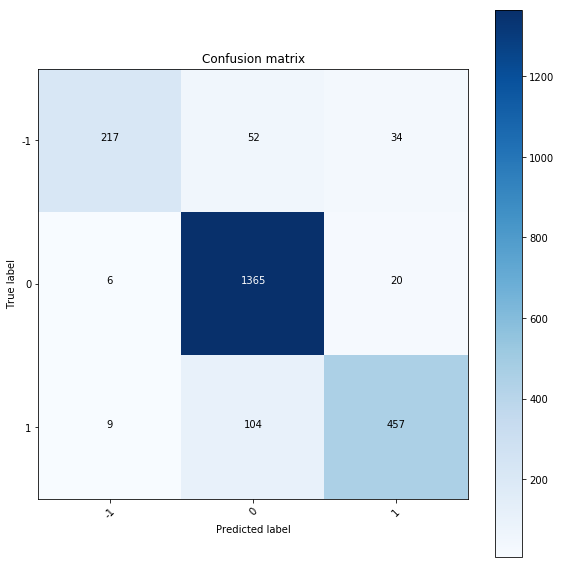

In [6]:
alpha=0.2
binary = True
ngram_range = (1,3)
use_fs = False
use_idf = False

pipeline = [('vectorizer', CountVectorizer(ngram_range=ngram_range, binary=binary))]
if use_fs: pipeline.append(('feature-selector', SelectFromModel(ExtraTreesClassifier())))
if use_idf: pipeline.append(('transformer', TfidfTransformer()))
pipeline.append(('estimator', NBSVM(alpha=alpha, C=1.0, beta=0.25)))
    
classifier = Pipeline(pipeline)
classifier = classifier.fit(X, y)

accuracy, cm = cross_validate(classifier, X, y, n_splits=10, shuffle=True, random_state=None)
plot_confusion_matrix(cm, classes)
print("Average Accuracy = %0.3f." % (accuracy,))

path = './model/nbsvm-%s.pkl' % fname
joblib.dump(classifier, path)
classifier_loaded = joblib.load(path)

In [ ]:
accuracy, cm = evaluate(classifier_loaded, X, y)
plot_confusion_matrix(cm, classes)
print("Accuracy = %0.3f." % (accuracy,))

## Sentence-Level Sentiment Analysis of Financial News Test Dataset

Accuracy = 0.159.


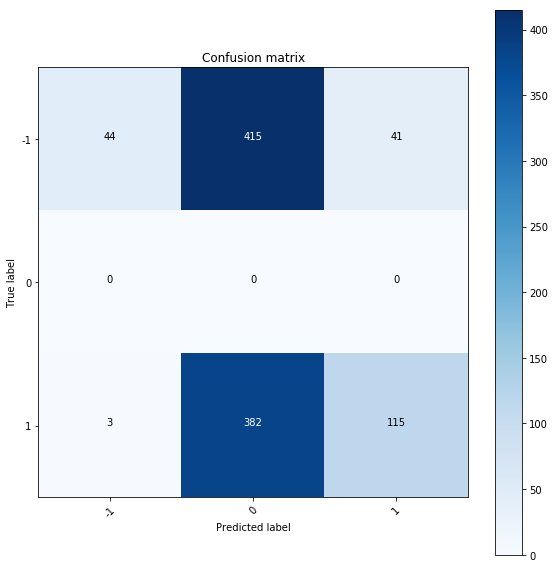

In [8]:
fname = 'sentence-level'
if include_words: fname = '%s-with-words' % fname
sl_sentences, sl_X, sl_y = load_data(fname + ".tsv")
sl_y = [-1 if code == 0 else 1 for code in sl_y]
accuracy, cm = evaluate(classifier_loaded, sl_X, sl_y)
plot_confusion_matrix(cm, classes)
print("Accuracy = %0.3f." % (accuracy,))

In [ ]:
sl_X[:10]